## LDA MODEL with GenSim and Spacy. Nishrin Kachwala

Detecting Topics in Nature based solutions platforms

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [298]:
#!ls '/content/drive/My Drive/Colab Notebooks/UDACITY'

In [2]:
!pip install -U gensim

     |████████████████████████████████| 24.2MB 1.2MB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [3]:
!python -q -m spacy download en_core_web_lg

     |████████████████████████████████| 827.9MB 1.1MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-cp37-none-any.whl size=829180944 sha256=6b03251c96fca79630b4b2631671392254665659619ca58efac3e329d7d18dff
  Stored in directory: /tmp/pip-ephem-wheel-cache-iyyk6hy1/wheels/2a/c1/a6/fc7a877b1efca9bc6a089d6f506f16d3868408f9ff89f8dbfc
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [4]:
!pip install langdetect

     |████████████████████████████████| 983kB 6.8MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.8-cp37-none-any.whl size=993193 sha256=baaba07a0e4499130dce73cb3bec01c25cc4d689152f8fa132bd1e6d93d8e50d
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d40a60ea06e6d669e8e5012e6c8b947a57
Successfully built langdetect


In [5]:
# Download the relevant utilities
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import gensim
import gensim.corpora as corpora

from gensim import models
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy
from spacy.lemmatizer import Lemmatizer
from spacy.lang.en.stop_words import STOP_WORDS 
import en_core_web_lg
from tqdm import tqdm_notebook as tqdm
from pprint import pprint

from collections import Counter 
import re

from nltk.corpus import stopwords

from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer
import requests
import string
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


#Data Extract Transform and Load

In [6]:
#Download the file scraped from various NbS websites
lsc = pd.read_csv('/content/drive/My Drive/Colab Notebooks/UDACITY/output1_ls.csv')

In [7]:
print('list shape is:', lsc.shape)
print('list cols are:', lsc.columns)

list shape is: (12801, 4)
list cols are: Index(['Unnamed: 0', 'Unnamed: 0.1', 'website_link', 'description'], dtype='object')


In [8]:
lsc.head()

Unnamed: 0  ...                                        description
0           0  ...  The BNCFF helps to create opportunities for in...
1           1  ...  We cover all renewable energy business activit...
2           2  ...  For lighting public highways, gardens, parks, ...
3           3  ...  Advisory of project owners and investors for t...
4           4  ...  Sale and installation of solar equipment direc...

[5 rows x 4 columns]

In [9]:
lsc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12801 entries, 0 to 12800
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    12801 non-null  int64 
 1   Unnamed: 0.1  12801 non-null  int64 
 2   website_link  12801 non-null  object
 3   description   12801 non-null  object
dtypes: int64(2), object(2)
memory usage: 400.2+ KB


In [10]:
lsc.isna().sum()   # There are no missing elements in the dataframe

Unnamed: 0      0
Unnamed: 0.1    0
website_link    0
description     0
dtype: int64

In [11]:
df = lsc[['website_link', 'description' ]]

In [12]:
df.shape

(12801, 2)

In [18]:
#Find the most commomly occuring words in the documents and add to stop list
def find_comm(data, num):
    ''' Find the most commomly occuring words in the documents and add to stop list
    Input: the document columns
    Output: stop word list
    '''

    #counter_comm_words = Counter(" ".join(df["description"]).split()).most_common(100) 
    counter_comm_words = Counter(" ".join(data).split()).most_common(num) 
    counter_comm_words 
    comm = pd.DataFrame(counter_comm_words, columns = ['Word','Count']) #Using Counter method

    ##creating new additions for stopwords from the most common words
    stop_list = comm['Word'][0:num].to_list() 
    # add other additional stop words
    add_stop_words = ["crs", "help", "year", "s", "program", "need", "service", 
    "catholic", "mix", "parallel", "day", 'water', 'school', 'photo', 'child', 
    'support','water', 'community','work', 'find', 'a', 'like' , 'are','as', 
    'was', 'at', 'it', 'been', 'with', 'will', 'no', 'or', 'this', 'over', 'buy',
    'about', 'there', 'high', 'possible', 'actually', 'time', 'follow', 'lead', 
    'effect', 'recent', 'use', 'likely', 'core', 'have', 'cause', 'come', 'hear',
    'present', 'actual', 'peerreviewe', 'relate', 'short', 'et', 'al', 'eu', 
    'come', 'use', 'als', 'th', 'need', 'follow', 'support', 'require', 'grow',
    'change', 'potential', 'important', 'include', 'project','family', 'g',
    'on','has','than','from', 'for', 'more', 'not', 'be',  'group', 'system',
    'small', 'pay', 'buy', 'eg', 'company']
    # extend the stop list
    stop_list.extend(add_stop_words)
    
    return stop_list

In [19]:
stop_list = find_comm(df["description"], 100)

In [20]:
stop_list[-10:-1]

['more', 'not', 'be', 'group', 'system', 'small', 'pay', 'buy', 'eg']

In [21]:
def clean(data, stop_list=stop_list):
    ''' 
        Using Regex to clean the columns. Make lower case, remove numbers and signs
        Clean up URL to root domain, remove duplicate, rows with less than 5 words
        Remove duplicates and less than 3 characters in a document
        Select only Engligh Lanuage texts
        Input: Data Col with the description and Website link
        Output: The clean and tokenized columns with URL's as Root Domain
    '''
    import regex as re

    def domain_extractor(u):
        ''' This function cleans up the URL and provide domain names
            Input: Column of websites
            Output: Column of Root Domains
        '''
        return re.search('\/\/([a-z.0-9A-Z-]*)\/',u+'/').group(1).replace('www.','')

    #Apply the function
    data['Root domain'] = data['website_link'].apply(lambda x: domain_extractor(x))

    # Clean and Tokenize
    
    data['clean'] = data.loc[:,'description'].str.lower()

    data['clean'] = data.loc[:,'clean'].apply(lambda x: re.sub(r'[^\w\d\s\']+', '', x))

    # removing numbers and $ signs from the column
    data['clean'] = data.loc[:,'clean'].str.replace(r'[0-9]', '')  

    data['clean_token'] = data['clean'].apply(word_tokenize)
    data['clean_token'] = data['clean_token'].apply(lambda x: [word for word in x if word not in stop_list])
    data['clean_token_join'] = [' '.join(map(str, l)) for l in data['clean_token']]

    # Define a function that splits a string sentence and counts the words
    '''Input : a string as text
        Output: a count of words in the string
    '''
    def word_count(string):
        res = len(string.split())
        return res
    # Apply word_count to clean description    
    data.loc[:,'word count'] = data.loc[:, ('clean_token_join')].apply(lambda x: word_count(str(x)))

    # drop of rows in with less than 5 words in wordcount
    data = data[data['word count'] > 5]

    # Drop any duplicate rows
    data.drop_duplicates(subset=['clean_token_join'], inplace=True)

    # Remove words with 3 characters or less
    def remove_three(x):
        temp = x.split()
        result = []
        for word in temp:
            if len(word) > 3:
                result.append(word)
        return " ".join(result)

    data['clean_token_join'] = data['clean_token_join'].apply(lambda x: remove_three(x)) 

    return data

In [22]:
clean(df, stop_list)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

website_link  ... word count
0                          http://bluenaturalcapital.org  ...        227
1             http://canopy-energy.com/en/canopy-energy/  ...         17
2      http://canopy-energy.com/en/construction-energ...  ...         38
3      http://canopy-energy.com/en/developpement-ener...  ...         62
4      http://canopy-energy.com/en/distribution-energ...  ...        137
...                                                  ...  ...        ...
12796  https://www2.cifor.org/asia-pacific-rainforest...  ...        119
12797  https://www2.cifor.org/asia-pacific-rainforest...  ...         18
12798  https://www2.cifor.org/asia-pacific-rainforest...  ...        853
12799  https://www2.cifor.org/asia-pacific-rainforest...  ...        301
12800  https://www2.cifor.org/world-conference-on-for...  ...         81

[12530 rows x 7 columns]

In [23]:
# Checking to see if all rows are in English
from langdetect import detect
def is_en(txt):
    try:
        return detect(txt)
    except:
        return False   

df['lanuage'] = df['clean_token_join'].apply(lambda x: is_en(x))

df = df[df.lanuage == 'en']    

In [24]:
df.lanuage.nunique()

1

In [25]:
#Save the cleaned file
df.to_csv('/content/drive/My Drive/Colab Notebooks/UDACITY/output1_ls_cleaned_final.csv')

In [26]:
nlp= spacy.load("en")


In [28]:
# list of stop words.
# Updates spaCy's default stop words list with  additional words. 
nlp.Defaults.stop_words.update(stop_list)

# Iterates over the words in the stop words list and resets the "is_stop" flag.
for word in nlp.Defaults.stop_words:
    lexeme = nlp.vocab[word]
    lexeme.is_stop = True


In [29]:
df_doc = df['clean_token_join'].copy()

Lemmatize and Remove stopwords

In [30]:
def pron_lemmatizer(doc):
    '''
    This takes in a doc of tokens from the NER and lemmatizes them. 
    Pronouns (like "I" and "you" get lemmatized to '-PRON-', so I'm removing those.
    '''
    doc = [token.lemma_ for token in doc if token.lemma_ != '-PRON-']
    doc = u' '.join(doc)
    return nlp.make_doc(doc)
    
def remove_sws(doc):
    '''This will remove stopwords and punctuation.
    Use token.text to return strings, which we'll need for Gensim.
    '''
    doc = [token.text for token in doc if token.is_stop != True and token.is_punct != True]
    return doc

# The add_pipe function appends these functions to the default pipeline.
nlp.add_pipe(remove_sws, name="sw", last=True)
nlp.add_pipe(pron_lemmatizer,name='lemm_pron',after='ner')


In [31]:
doc_list = []
# Iterates through each article in the corpus.
for doc in tqdm(df_doc):
    # Passes that article through the pipeline and adds to a new list.
    pr = nlp(doc)
    doc_list.append(pr)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [32]:
# Using gensim corpora create a dictionary, which is a mapping of word IDs to words.
words = corpora.Dictionary(doc_list)

#words.filter_extremes(no_below=4, no_above=0.5, keep_n=100000)

# Turns each document into a bag of words.
corpus = [words.doc2bow(doc) for doc in doc_list]

In [33]:
len(corpus)

11770

#LDA MODEL
**Parameters in the model:**
*   *passes* controls how often we train the model on the entire corpus (set to 100)
chunksize controls how many documents are processed at a time in the training algorithm.
*   *chunksize* controls how many documents are processed at a time in the training algorithm.
*   *Dirichlet hyperparameter alpha* is the Document-Topic Density
*   *Dirichlet hyperparameter beta* is Word-Topic Density
*   *Perplexity* is a statistical measure of how well a probability model predicts a sample the statistic makes more sense when comparing it across different models with varying the number of topics. The model with the lowest perplexity is generally considered the “best”

* Model topic coherence Score: This score is a measure to judge how good a given topic model is.  *Topic Coherence* measures score a single topic by measuring the degree of semantic similarity between high scoring words in the topic.








In [34]:
# TUNING FOR OPTIMUM TOPIC NUMBER BASED ON PERPELXITY AND COHERENCE
def compute_coherence_values(corpus,  id2word, texts, limit, start=3, step=4):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    
    coherence_values = []
    perplexity_values =[]
    model_list = []
    
    #   
    for num_topics in range(start, limit, step):  
        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=words,
                                           num_topics=num_topics, 
                                           random_state=2,
                                           update_every=1,
                                           chunksize=50,
                                           passes=10,
                                           alpha='auto',
                                           iterations=500,
                                           per_word_topics=True)
        
        model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
        model_list.append(model_lda)

        coherence_values.append(model_lda.get_coherence())
        perplexity_values.append(lda_model.log_perplexity(corpus))
    
    return  model_list, coherence_values, perplexity_values
    

Takes a long time to run, a few hours.

In [326]:
#model_list, coherence_values, perplexity_values = compute_coherence_values(corpus=corpus, id2word=words, texts=doc_list, start=3, limit=25, step=3)  # comment out after optimized for numberof Topics

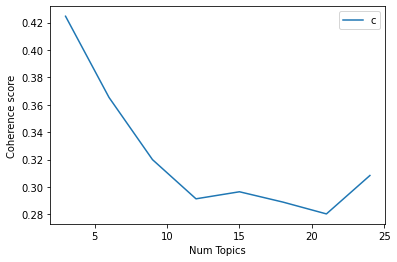

In [327]:
limit=25; 
start=3; 
step=3; 
x = range(start, limit, step) 
#plt.plot(x, coherence_values)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics") 
plt.ylabel("Coherence score") 
plt.legend(("coherence_values"), loc='best') 
plt.show()

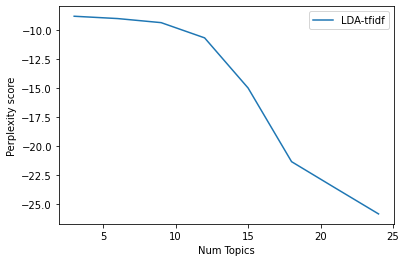

In [328]:
limit=25;
start=3; 
step=3; 
x = range(start, limit, step) 
#plt.plot(x, perplexity_values, label="LDA") 
plt.plot(x, perplexity_values, label="LDA-tfidf")


plt.xlabel("Num Topics") 
plt.ylabel("Perplexity score") 
plt.legend() 
plt.show()

In [35]:
# FINAL LDA model based on optimized Topic number
final_num_topics = 12
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=words,
                                           num_topics=final_num_topics, 
                                           random_state=2,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           iterations=500,
                                           per_word_topics=True)

In [36]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. The lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=doc_list, dictionary=words, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
perplexity_value = lda_model.log_perplexity(corpus)
print('\nCoherence Score: ', coherence_lda)
#print('\nPerpelxity:', perplexity_value)


Perplexity:  -10.637189284827521

Coherence Score:  0.3208296690593668


In [37]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.039*"plant" + 0.032*"human" + 0.028*"risk" + 0.024*"village" + 0.021*"increase" + 0.021*"household" + 0.020*"population" + 0.016*"infrastructure" + 0.016*"drought" + 0.014*"nature"
Topic: 1 Word: 0.054*"report" + 0.048*"million" + 0.033*"information" + 0.029*"africa" + 0.027*"meet" + 0.027*"face" + 0.026*"role" + 0.025*"activity" + 0.025*"variety" + 0.020*"region"
Topic: 2 Word: 0.101*"vision" + 0.053*"overcome" + 0.051*"concept" + 0.043*"malawi" + 0.038*"childhood" + 0.031*"sharing" + 0.016*"warning" + 0.015*"airport" + 0.009*"mid" + 0.007*"meter"
Topic: 3 Word: 0.051*"health" + 0.035*"organization" + 0.028*"share" + 0.025*"diversity" + 0.024*"address" + 0.020*"plan" + 0.019*"fund" + 0.017*"tool" + 0.016*"offer" + 0.016*"problem"
Topic: 4 Word: 0.039*"provide" + 0.028*"impact" + 0.027*"opportunity" + 0.020*"focus" + 0.020*"city" + 0.019*"benefit" + 0.019*"biodiversity" + 0.019*"area" + 0.017*"effort" + 0.016*"security"
Topic: 5 Word: 0.110*"business" + 0.074*"governme

#VISUALIZE RESULTS

In [38]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=doc_list):
    ''' Function provides details on the dominant topics: 
        the main topic in each document: the Dominant topic, Perc Contribution 
        and Keywords for each document
        Input:ldamodel, the corpus and list of documents
        Output: Text, dominat topics in text, its percent contribution and the Topic keywords
    '''
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    
    return(sent_topics_df)


In [39]:
df_topic_sent_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=doc_list)

# Create a Dominant topic dataframe columns
df_dominant_topic = df_topic_sent_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head()
df_dominant_topic['Dominant_Topic'].unique()

array([ 4.,  7.,  1., 11.,  9.,  6.,  0.,  3.])

In [40]:
df_dominant_topic.head()

Document_No  ...                                               Text
0            0  ...  [bncff, create, opportunity, investor, build, ...
1            1  ...  [cover, renewable, energy, business, activity,...
2            2  ...  [light, public, highway, garden, park, public,...
3            3  ...  [advisory, owner, investor, purchase, sale, fi...
4            4  ...  [sale, installation, solar, equipment, directl...

[5 rows x 5 columns]

In [41]:
df_dominant_topic.groupby('Dominant_Topic').count()

Document_No  Topic_Perc_Contrib  Keywords   Text
Dominant_Topic                                                  
0.0                       1                   1         1      1
1.0                       6                   6         6      6
3.0                      49                  49        49     49
4.0                      51                  51        51     51
6.0                      23                  23        23     23
7.0                   11521               11521     11521  11521
9.0                      75                  75        75     75
11.0                     44                  44        44     44

In [42]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sent_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)
# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf.head()

Topic_Num  ...                                                                                  Representative Text
0        0.0  ...  [current, unprecedented, expansion, infrastructure, promise, enhance, human, wellbeing, risk, su...
1        1.0  ...  [shapefile, dataset, describe, fourth, version, database, administrative, unit, associate, popul...
2        3.0  ...  [shapefile, dataset, describe, soil, base, saturation, subsoil, congothe, dataset, derive, faoun...
3        4.0  ...  [bncff, create, opportunity, investor, build, future, bncff, focus, coastal, ecosystem, key, bio...
4        6.0  ...  [annual, runoff, rof, calculate, base, balance, model, antonio, t, ipcc, ar, dataset, available,...

[5 rows x 4 columns]

In [43]:
len(df_topic_sent_keywords)

11770

In [44]:
len(sent_topics_sorteddf)

8

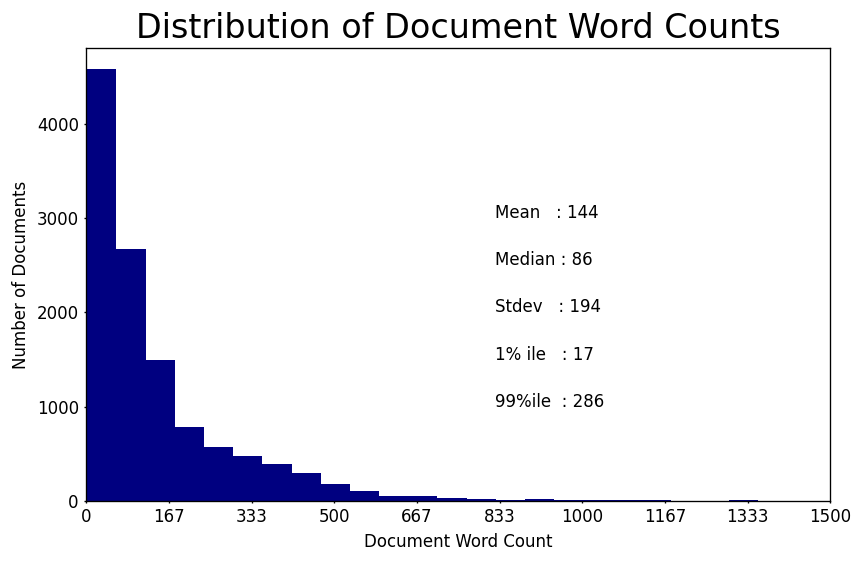

In [45]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(8,5), dpi=120)
plt.hist(doc_lens, bins = 100, color='navy')
plt.text(825, 3000, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(825,  2500, "Median : " + str(round(np.median(doc_lens))))
plt.text(825,  2000, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(825,  1500, "1% ile   : " + str(round(np.quantile(doc_lens, q=0.15))))
plt.text(825,  1000, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.85))))

plt.gca().set(xlim=(0, 1500), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=1)
plt.xticks(np.linspace(0,1500,10))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=20))
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


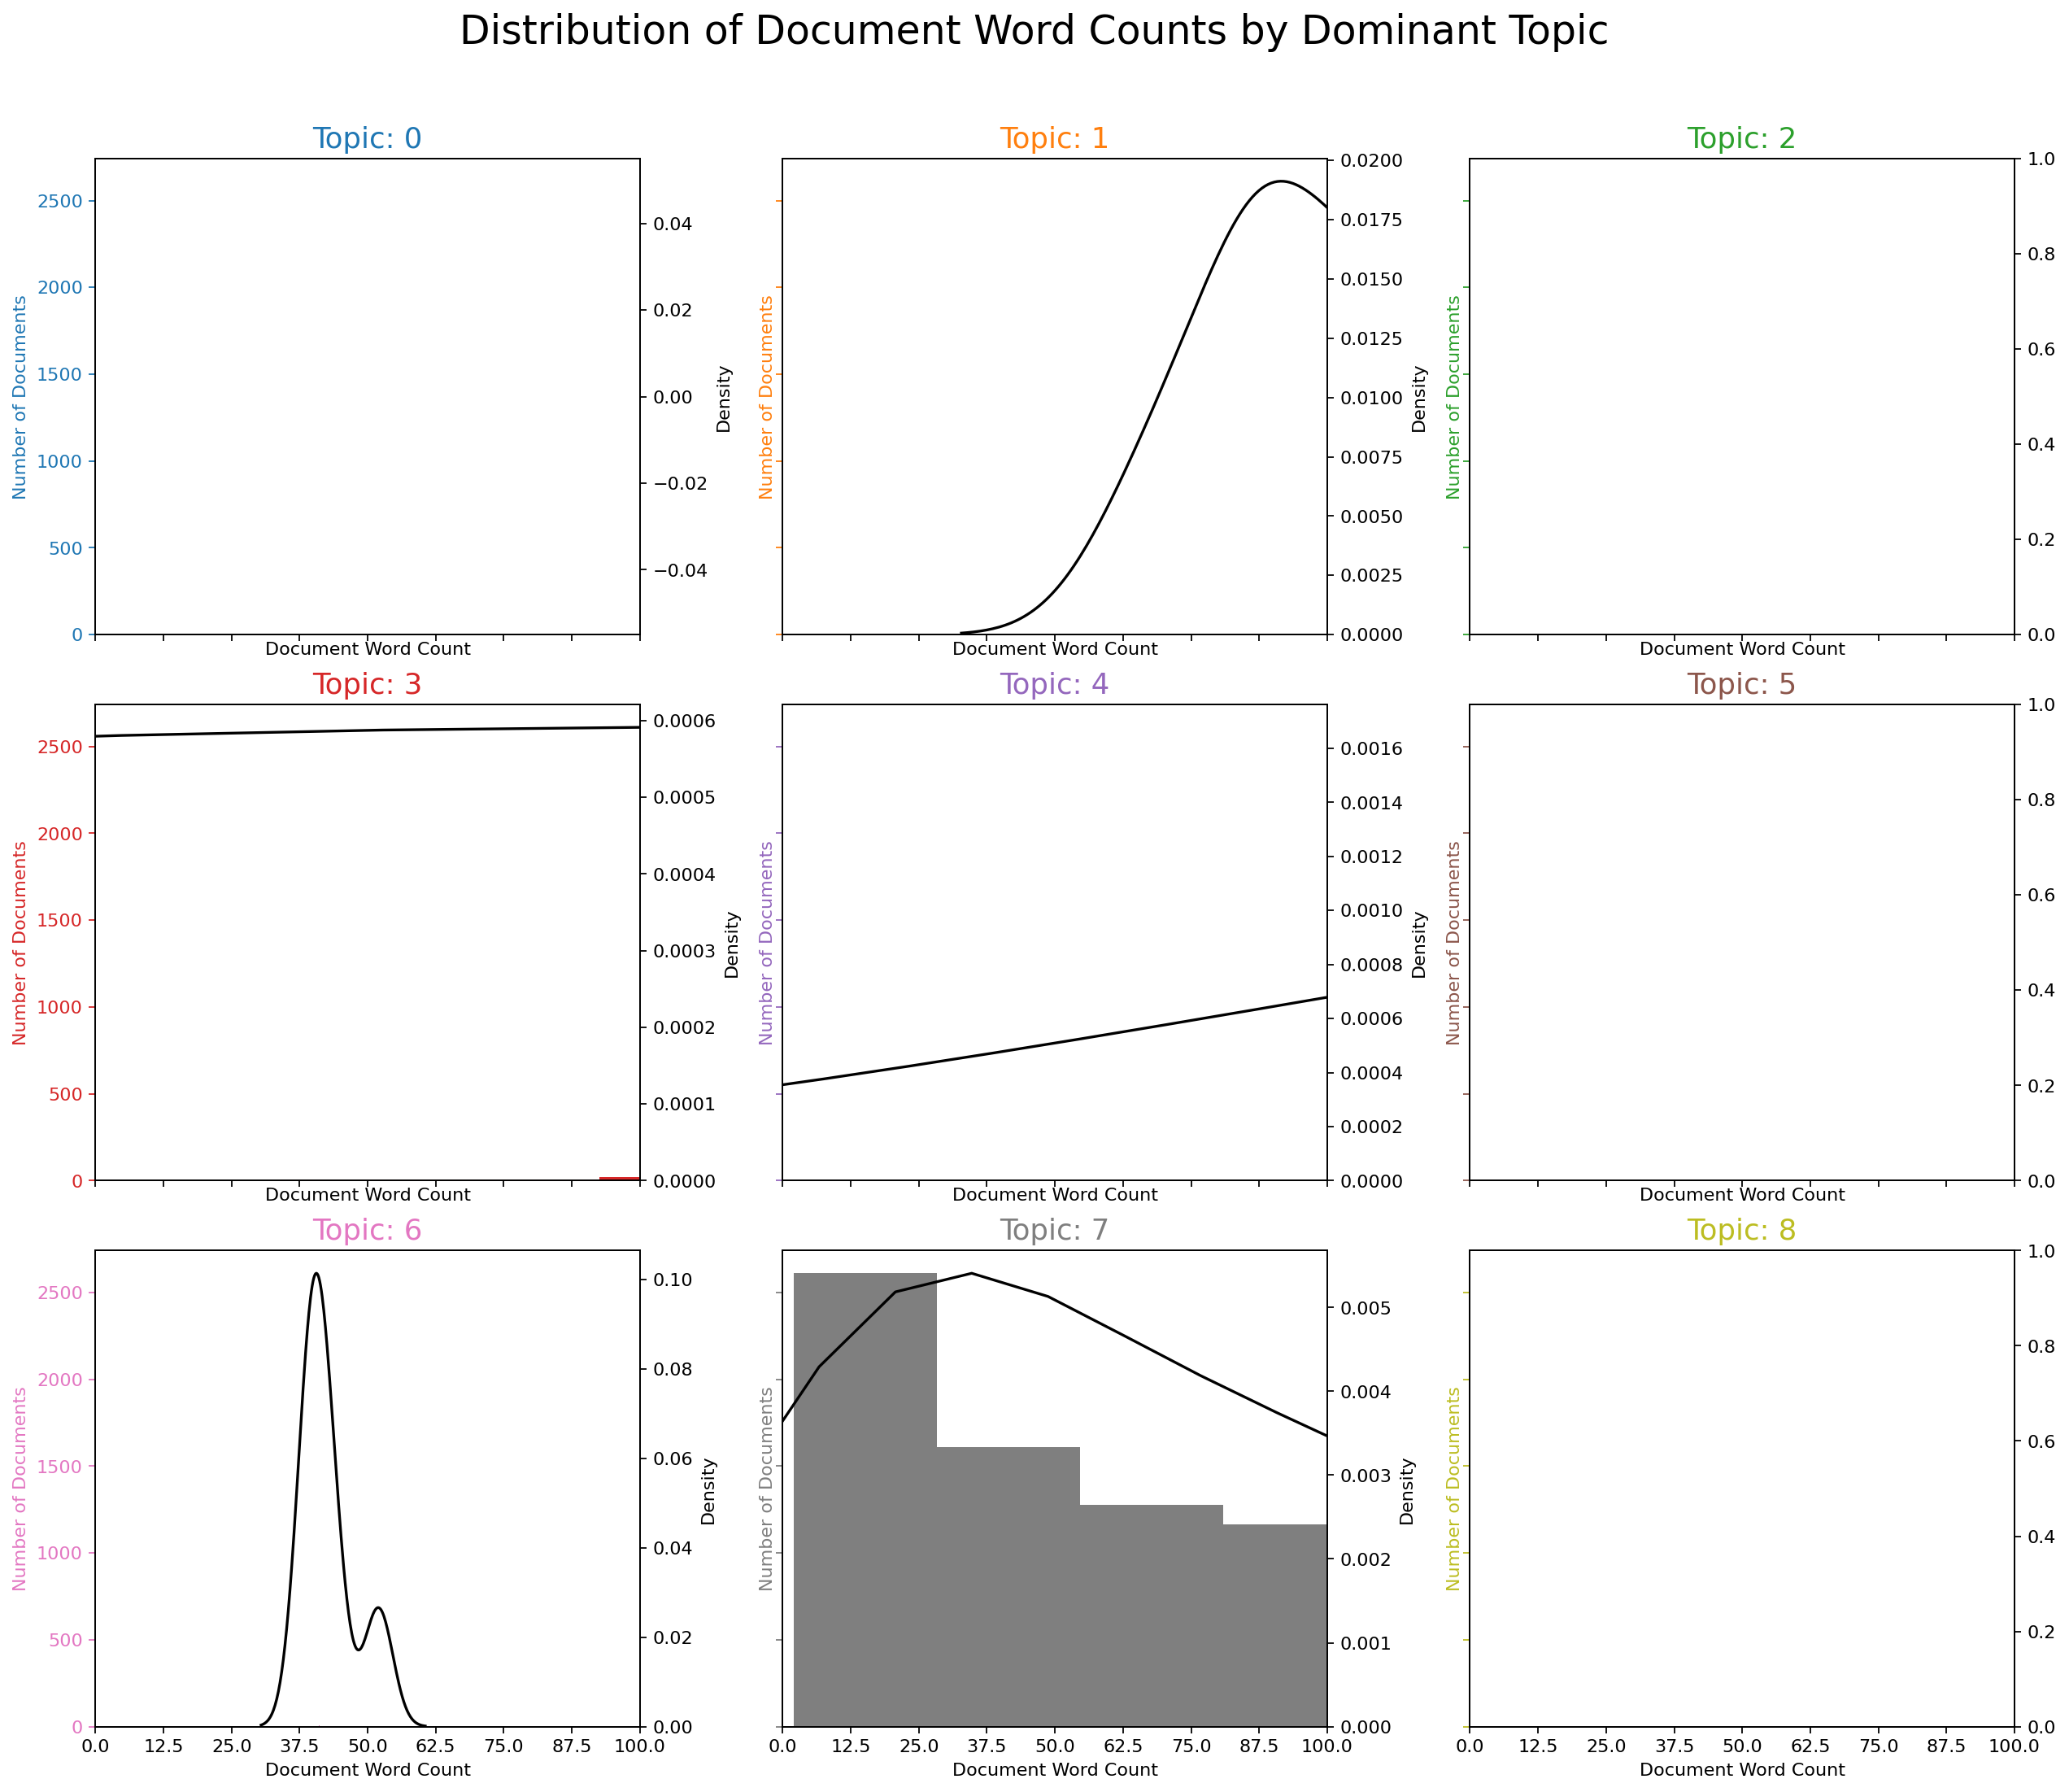

In [47]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(3,3,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 100, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 100), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,100,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

In [49]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud
import matplotlib.colors as mcolors

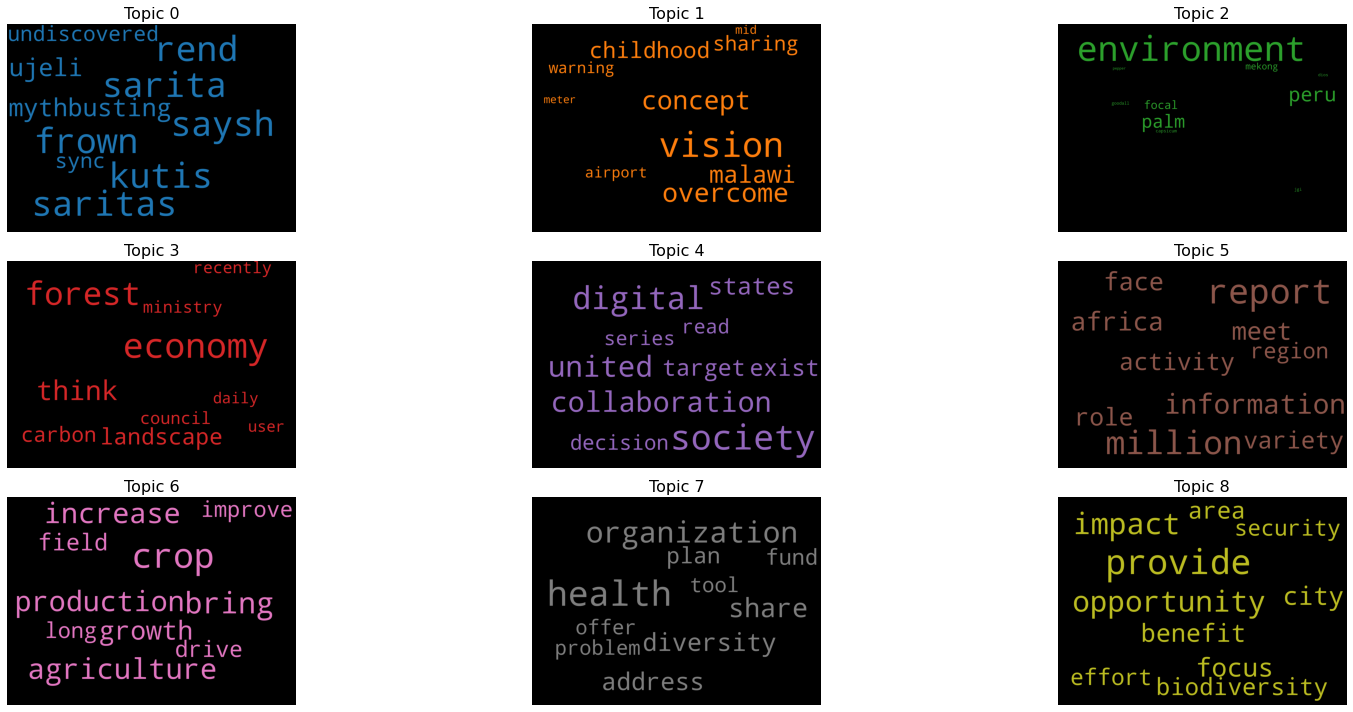

In [52]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stopwords,
                  background_color='black',
                  width=2500,
                  height=1800,
                  max_words=12,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(3, 3, figsize=(25,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

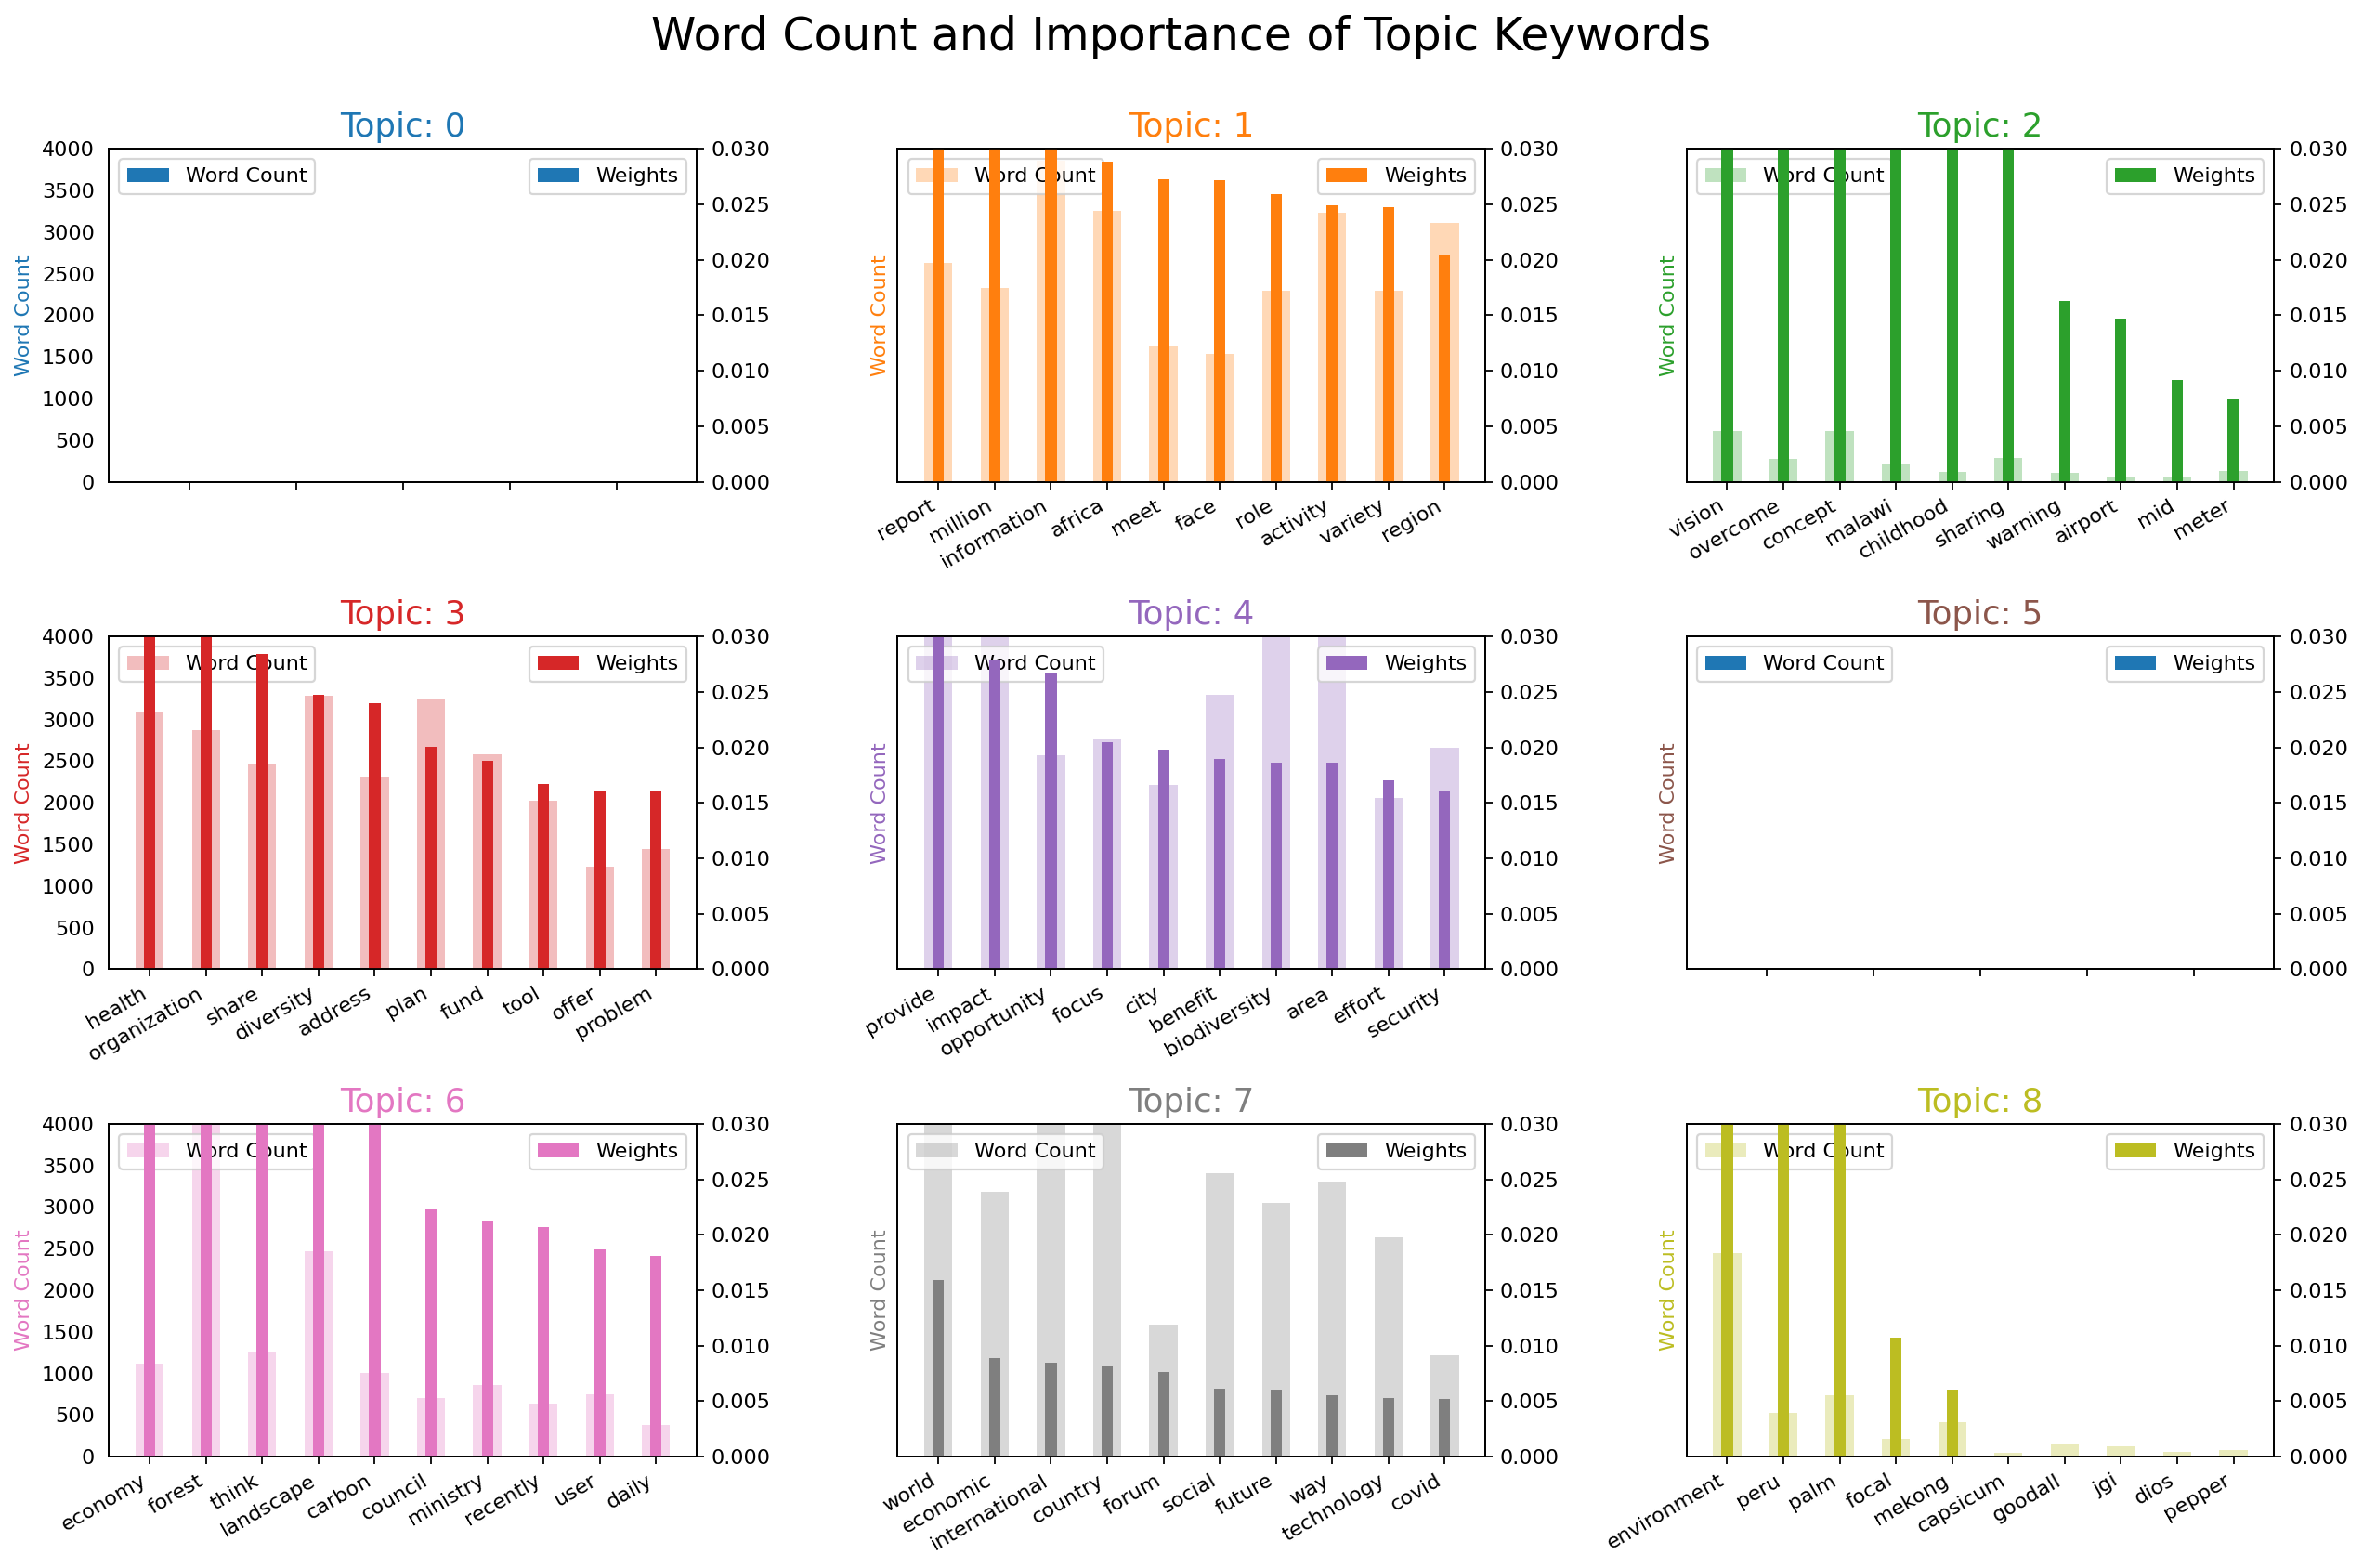

In [53]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in doc_list for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(3, 3, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 4000)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

The total number of documents attributed to each topic

In [54]:
def topics_per_document(model, corpus, start=0, end=-1):
    '''The total number of documents attributed to each topic
        Input:Model and Corpus
        Output:Returns the dominant topics and topic percentage in each document
    '''
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 5 Keywords for each Topic
topic_top5words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top5words_stacked = pd.DataFrame(topic_top5words, columns=['topic_id', 'words'])
df_top5words = df_top5words_stacked.groupby('topic_id').agg(', \n'.join)
df_top5words.reset_index(level=0,inplace=True)

In [345]:
df_top5words.head(11)

topic_id                             words
0         0        village, \nnetwork, \nsell
1         1  business, \nhealth, \ntechnology
2         2              meet, \nface, \nrole
3         3   government, \napproach, \nvalue
4         4     economic, \nprovide, \nsocial
5         5   world, \nforum, \ninternational
6         7             crop, \ntree, \nbring
7         8            field, \npoint, \nrate
8         9           meter, \nrust, \ngeneva
9        10      organization, \nplan, \nfund

In [55]:
lda_model.show_topics(formatted=True)

[(10,
  '0.000*"kutis" + 0.000*"frown" + 0.000*"saysh" + 0.000*"saritas" + 0.000*"sarita" + 0.000*"rend" + 0.000*"mythbusting" + 0.000*"ujeli" + 0.000*"undiscovered" + 0.000*"sync"'),
 (2,
  '0.101*"vision" + 0.053*"overcome" + 0.051*"concept" + 0.043*"malawi" + 0.038*"childhood" + 0.031*"sharing" + 0.016*"warning" + 0.015*"airport" + 0.009*"mid" + 0.007*"meter"'),
 (8,
  '0.339*"environment" + 0.049*"peru" + 0.040*"palm" + 0.011*"focal" + 0.006*"mekong" + 0.000*"capsicum" + 0.000*"goodall" + 0.000*"jgi" + 0.000*"dios" + 0.000*"pepper"'),
 (6,
  '0.110*"economy" + 0.094*"forest" + 0.064*"think" + 0.043*"landscape" + 0.036*"carbon" + 0.022*"council" + 0.021*"ministry" + 0.021*"recently" + 0.019*"user" + 0.018*"daily"'),
 (9,
  '0.063*"society" + 0.052*"digital" + 0.044*"united" + 0.042*"collaboration" + 0.029*"states" + 0.027*"exist" + 0.027*"target" + 0.021*"decision" + 0.019*"read" + 0.019*"series"'),
 (1,
  '0.054*"report" + 0.048*"million" + 0.033*"information" + 0.029*"africa" + 0.

In [56]:
df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()

8

# TSNE (t-distributed stochastic neighbor embedding) algorithm to visualize the clusters of documents in 2D space with Bokeh

In [67]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label, ColumnDataSource, HoverTool, LinearColorMapper, CustomJS, Slider, TapTool, TextInput
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points 
#arr = arr[np.amax(arr, axis=1) > 0.3]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)


# tSNE Dimension Reduction with pca initialization
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, init='pca')
tsne_lda = tsne_model.fit_transform(arr)



[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 11770 samples in 0.016s...
[t-SNE] Computed neighbors for 11770 samples in 1.257s...
[t-SNE] Computed conditional probabilities for sample 1000 / 11770
[t-SNE] Computed conditional probabilities for sample 2000 / 11770
[t-SNE] Computed conditional probabilities for sample 3000 / 11770
[t-SNE] Computed conditional probabilities for sample 4000 / 11770
[t-SNE] Computed conditional probabilities for sample 5000 / 11770
[t-SNE] Computed conditional probabilities for sample 6000 / 11770
[t-SNE] Computed conditional probabilities for sample 7000 / 11770
[t-SNE] Computed conditional probabilities for sample 8000 / 11770
[t-SNE] Computed conditional probabilities for sample 9000 / 11770
[t-SNE] Computed conditional probabilities for sample 10000 / 11770
[t-SNE] Computed conditional probabilities for sample 11000 / 11770
[t-SNE] Computed conditional probabilities for sample 11770 / 11770
[t-SNE] Mean sigma: 0.018707
[t-SNE] KL divergence

In [68]:
xx =tsne_lda[:,0]
print(xx)

[ 68.17538  -52.142323 -18.971693 ...   8.494833 -26.407112  18.145073]


In [69]:
yy = tsne_lda[:,1]
print(yy)

[ 36.649864  44.537285  41.830128 ...  20.140722 -28.986534 -45.553635]


In [70]:
print(topic_num)

[3 6 6 ... 6 6 6]


In [71]:
# Plot the Topic Clusters using Bokeh
import matplotlib.colors as mcolors
output_notebook()
n_topics = 12
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(topic_num), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

In [72]:
len(corpus)

11770

In [73]:
!pip install pyldavis

     |████████████████████████████████| 1.7MB 6.8MB/s 
  Created wheel for pyldavis: filename=pyLDAvis-3.2.2-py2.py3-none-any.whl size=135593 sha256=4992863d383bb90495a17d664236ae0def10148bc17ef6bd1981a1d2d72ec6fe
  Stored in directory: /root/.cache/pip/wheels/74/df/b6/97234c8446a43be05c9a8687ee0db1f1b5ade5f27729187eae
Successfully built pyldavis


In [74]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.225716 -0.361096       1        1  51.318294
4     -0.196271  0.049927       2        1  11.520853
3     -0.152172  0.180455       3        1   8.938177
11    -0.137339 -0.072689       4        1   6.855772
1     -0.109550  0.161631       5        1   5.908050
0     -0.106880 -0.001098       6        1   5.624191
5      0.001058  0.123861       7        1   3.798663
9      0.036868  0.063319       8        1   3.110793
6      0.105578  0.008804       9        1   2.398595
8      0.261476 -0.049933      10        1   0.319605
2      0.261853 -0.050144      11        1   0.204425
10     0.261096 -0.053038      12        1   0.002583, topic_info=            Term         Freq        Total Category  logprob  loglift
151     business  7099.000000  7099.000000  Default  30.0000  30.0000
174       health  7676.000000  7676.000000  Default  29.0000  29.0000
1270     economy  4455.000000  4455.000000  Default  28.0000  28.0000
113      provide  9418.000000  9418.000000  Default  27.0000  27.0000
643   government  4795.000000  4795.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
25          blue     0.000664   155.687127  Topic12 -11.0965  -1.8016
26         bncff     0.000664     0.803474  Topic12 -11.0965   3.4651
27      brochure     0.000664    13.514684  Topic12 -11.0965   0.6425
28       browser     0.000664    94.120513  Topic12 -11.0965  -1.2983
29         build     0.000664  3543.379526  Topic12 -11.0965  -4.9266

[514 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
227       2  0.999418   ability
0         1  0.921268    access
0         5  0.078326    access
1         2  0.999724   achieve
1886      1  0.943835    action
...     ...       ...       ...
4060      1  0.999779     woman
1296      7  0.999521  workshop
490       1  0.975833     world
490       8  0.024147     world
1114      6  0.999631     yield

[459 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 5, 4, 12, 2, 1, 6, 10, 7, 9, 3, 11])

#TOPICS VISUALIZATION with t-SNE

In [75]:
tp = df_dominant_topic.copy()  # Create a copy of the Dominant Topic dataframe for t-SNE visuals.

In [76]:

print(tp.shape)
tp.head()


(11770, 5)


Document_No  ...                                                                                                 Text
0            0  ...  [bncff, create, opportunity, investor, build, future, bncff, focus, coastal, ecosystem, key, bio...
1            1  ...  [cover, renewable, energy, business, activity, solar, market, segment, specialist, finance, larg...
2            2  ...  [light, public, highway, garden, park, public, private, space, private, industrial, site, hotel,...
3            3  ...  [advisory, owner, investor, purchase, sale, financing, solar, biofuel, energy, client, completio...
4            4  ...  [sale, installation, solar, equipment, directly, final, customer, private, individual, municipal...

[5 rows x 5 columns]

In [77]:
tp = tp.dropna(axis=0)


In [360]:
tp.shape

(11773, 5)

In [361]:
tp['Dominant_Topic'] = tp['Dominant_Topic'].apply(lambda x: str(int(x)))

In [113]:
tp.sample(5)

Document_No  ...  Topic
6092          6092  ...       
10427        10427  ...       
81              81  ...       
197            197  ...       
9154          9154  ...       

[5 rows x 6 columns]

# Manually inspected texts and Keywords in each Topic to assigned Topic descriptions to a Topic label. This requires Climate Change Domain Expertise.

In [155]:
topic_labels = {0: 'Increase in planting infrastructure to reduce drought', 1: 'Africa\'s regional activity for Climate change', 2: 'Malawi\'s vision to overcome Climate change', 3: 'Health organization Funds', 4: 'Cities benefit from biodiversity', 5: 'Business and Government partnerships helping farmers', 6:'Forests helping economy and Carbon footprint', 7: 'World Economic Forum addresses COVID', 8: 'Environmentally fragile locations', 9:'Digital collaboration helping Climate Change', 10:'Conservancy efforts for Climate Change', 11:'Increased Agriculture production driven by NbS' }

In [157]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.039*"plant" + 0.032*"human" + 0.028*"risk" + 0.024*"village" + 0.021*"increase" + 0.021*"household" + 0.020*"population" + 0.016*"infrastructure" + 0.016*"drought" + 0.014*"nature"
Topic: 1 Word: 0.054*"report" + 0.048*"million" + 0.033*"information" + 0.029*"africa" + 0.027*"meet" + 0.027*"face" + 0.026*"role" + 0.025*"activity" + 0.025*"variety" + 0.020*"region"
Topic: 2 Word: 0.101*"vision" + 0.053*"overcome" + 0.051*"concept" + 0.043*"malawi" + 0.038*"childhood" + 0.031*"sharing" + 0.016*"warning" + 0.015*"airport" + 0.009*"mid" + 0.007*"meter"
Topic: 3 Word: 0.051*"health" + 0.035*"organization" + 0.028*"share" + 0.025*"diversity" + 0.024*"address" + 0.020*"plan" + 0.019*"fund" + 0.017*"tool" + 0.016*"offer" + 0.016*"problem"
Topic: 4 Word: 0.039*"provide" + 0.028*"impact" + 0.027*"opportunity" + 0.020*"focus" + 0.020*"city" + 0.019*"benefit" + 0.019*"biodiversity" + 0.019*"area" + 0.017*"effort" + 0.016*"security"
Topic: 5 Word: 0.110*"business" + 0.074*"governme

In [159]:
tp['Dominant_Topic'] = tp['Dominant_Topic'].apply(lambda x: str(int(x)))  # convert Dominant topic float values to int values to string.

In [160]:
tp.head(2)

Document_No  ...                                                                                                 Text
0            0  ...  [bncff, create, opportunity, investor, build, future, bncff, focus, coastal, ecosystem, key, bio...
1            1  ...  [cover, renewable, energy, business, activity, solar, market, segment, specialist, finance, larg...

[2 rows x 5 columns]

In [161]:
# Assigning a Topic Description to a Topic Number from the topic_labels dictionary above
tp['Topic']= ""
for i in range(len(tp)):
    for j in range(final_num_topics):
        #print(i, k)
        if tp['Dominant_Topic'][i] == str(j):
            #print(i, k)
            tp['Topic'][i] = topic_labels[j]
           

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [162]:
tp.head()

Document_No  ...                                 Topic
0            0  ...      Cities benefit from biodiversity
1            1  ...  World Economic Forum addresses COVID
2            2  ...  World Economic Forum addresses COVID
3            3  ...  World Economic Forum addresses COVID
4            4  ...      Cities benefit from biodiversity

[5 rows x 6 columns]

In [82]:
!pip install -U sentence-transformers   # Install transformers

     |████████████████████████████████| 71kB 3.7MB/s 
     |████████████████████████████████| 1.9MB 6.0MB/s 
     |████████████████████████████████| 1.2MB 23.2MB/s 
     |████████████████████████████████| 890kB 41.6MB/s 
     |████████████████████████████████| 3.2MB 51.4MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.4.1.2-cp37-none-any.whl size=103068 sha256=9f7c72c73213d5b5cb57d9ee7d101e0910c084f17e30ca49fa20be65f21820bc
  Stored in directory: /root/.cache/pip/wheels/3d/33/d1/5703dd56199c09d4a1b41e0c07fb4e7765a84d787cbdc48ac3
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=dc02f82d219d65088dc392415c1edb4ddb9322a6834880b62738f6c9872fc6c4
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sentence-transformers sacremoses


In [163]:
tsne=pd.read_csv('/content/drive/My Drive/Colab Notebooks/UDACITY/output1_ls_cleaned_final.csv', lineterminator='\n')    # for convenience reading the saved the cleaned tokenized file.

In [164]:
print(tsne.shape)
tsne.head(3)

(11770, 9)


Unnamed: 0  ... lanuage
0           0  ...      en
1           1  ...      en
2           2  ...      en

[3 rows x 9 columns]

In [166]:
final = pd.concat([tsne, tp], verify_integrity=True, axis=1)   # Combining the clean token dataframe with the 

In [167]:
final.head()  # Final data frmae to be used for sentence embeddings and 3D scatter plots

Unnamed: 0  ...                                 Topic
0           0  ...      Cities benefit from biodiversity
1           1  ...  World Economic Forum addresses COVID
2           2  ...  World Economic Forum addresses COVID
3           3  ...  World Economic Forum addresses COVID
4           4  ...      Cities benefit from biodiversity

[5 rows x 15 columns]

In [168]:
final.to_csv('/content/drive/My Drive/Colab Notebooks/UDACITY/output1_ls_tsne_final.csv')

In [169]:
print(final.shape)
final.head(3)

(11770, 15)


Unnamed: 0  ...                                 Topic
0           0  ...      Cities benefit from biodiversity
1           1  ...  World Economic Forum addresses COVID
2           2  ...  World Economic Forum addresses COVID

[3 rows x 15 columns]

Sentence Transforms

In [170]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('bert-base-nli-cls-token')
sentences = list(final['clean_token_join'])
sentence_embeddings = model.encode(sentences)

print("Sentence embeddings:")
print(sentence_embeddings)

Sentence embeddings:
[[-0.33838236 -0.52094716 -0.26272804 ... -0.6246958  -0.8961605
  -0.39456627]
 [-0.0545527  -0.22344065 -0.02147282 ... -0.0755919  -0.28710774
  -0.66720885]
 [ 0.4536957   1.1637163  -0.16524668 ... -0.4301404  -0.55516326
  -0.04988015]
 ...
 [-0.51171696  0.7504769  -0.60523134 ...  0.5106701   0.19188896
  -0.63367957]
 [-1.054461    0.37919793 -0.32296848 ... -0.55980885  0.26666924
  -1.0933385 ]
 [-1.0726556   0.7277468   0.07347111 ... -0.39093083  0.04434748
  -0.9884845 ]]


In [171]:
from sklearn.manifold import TSNE
import plotly.express as px

features = sentence_embeddings

Done once optimizations using various perplexity values, takes a long time to run.

In [373]:
#perplexities = [5, 15, 25, 35, 45, 65, 100]
#tsne2d = TSNE(n_components=2, random_state=0, perplexity=65)

In [172]:
tsne3d = TSNE(n_components=3, random_state=0, perplexity=65)    # Using the best perplexity from above, 65 running tsne3d

In [174]:
projections = tsne3d.fit_transform(features)

In [175]:
import plotly.express as px

#Experiments with different perplexity values
for perplexity in perplexities:

    tsne3d = TSNE(n_components=3, random_state=0, perplexity=perplexity)
    projections = tsne3d.fit_transform(features)
    fig = px.scatter(
    projections, x=0, y=1, color=tp.Dominant_Topic,  template="simple_white",
    labels = {
            '0': '', '1':'',  'color':'Topic',
        },
    title= "Perplexity=%d" % perplexity,

    width=1000, height=600
    )
    fig.update_traces(textposition='top center')
    fig.update_xaxes(showgrid=False)
    fig.update_yaxes(showgrid=False)
    fig.update_traces(marker_size=10, showlegend=True)
    fig.update_xaxes(showspikes=True)
    fig.update_yaxes(showspikes=True)
    fig.show()

In [ ]:
tsne.head()

In [176]:
fig = px.scatter(
    #projections, x=0, y=1, color=tsne.Dominant_Topic,  template="simple_white",
    projections, x=0, y=1, color=final['Root domain'],  template="simple_white",
    #projections, x=0, y=1, color=tsne['Root domain'],  labels={'color': 'Topic'}, template="simple_white",
    #hover_data=tp['claim_label'],
    #projections, x=0, y=1, color=tp.Topic, template="simple_white",
    #labels = {
     #       '0': '', '1':'',  'color':'Topic',
    #    },
    #hover_data = {'x': False, 'Claim label': [tp.claim_label], 'Aim' : [tp.Keywords]},
    hover_data = [final.Topic, final.Keywords],

    #hover_data = {'Root domain': df['Root domain'], 'Aim' : df['Topic']},

    width=1600, height=900
    )
fig.update_traces(textposition='top center')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.update_traces(marker_size=10, showlegend=True)
fig.update_xaxes(showspikes=True)
fig.update_yaxes(showspikes=True)
fig.show()

In [177]:
perplexity =65
fig1 = px.scatter_3d(
        projections, x=0, y=1, z = 2, color=final['Root domain'], template="plotly",
        #hover_data = {'Claim Label': [tp.claim_label], 'Topic' : [tp.Topic], 'Keywords': [tp.Keywords]},
        #hover_data = { 'Keywords': [tp.Keywords]},
        hover_data =[final.Topic,  final.Keywords],
        labels = {'0': 'x', '1':'y', '2':'z'},
        title= "Perplexity=%d" % perplexity,
        width=1600, height=700
    )
fig1.update_traces(marker_size=5)
fig1.update_traces(mode='markers', marker_size=5, marker_line_width=2)
fig1.update_layout(
    scene=dict(
        xaxis_title="",
        yaxis_title="",
        zaxis_title="",
        xaxis=dict(showticklabels=False, ticks=""),
        yaxis=dict(showticklabels=False, ticks=""),
        zaxis=dict(showticklabels=False, ticks=""),
        aspectratio_x=1.75, aspectratio_y=1.75, aspectratio_z=1.1
    ),
    margin=dict(l=0, r=0, b=1, t=0),
    legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
    )

)
fig1.show()

In [178]:
fig1.write_html("/content/drive/My Drive/Colab Notebooks/UDACITY/final_out1_65px_03082021.html")